In [12]:
import pandas as pd
import numpy as np
from collections import Counter
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/Leccion #5/tw_source.csv',
                      encoding='latin_1', header=None)
dataset.columns = ['valor', 'id', 'fecha', 'fuente', 'usuario', 'tweet']
dataset.head()

,valor,id,fecha,fuente,usuario,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


**Los 3 usuarios más populares**

In [23]:
# Extraer las menciones para cada usuario
dataset['mentions'] = dataset['tweet'].apply(lambda x: re.findall(r'@\w+', x))

# Expandir las menciones
mentions_expanded = dataset.explode('mentions')

# Contar las menciones para cada uno de los usuarios
top_users = mentions_expanded['mentions'].value_counts().head(3)
print(top_users)

mentions
@mileycyrus    4500
@tommcfly      3887
@ddlovato      3467
Name: count, dtype: int64


**Crear el corpus**

In [25]:
# Crear la lista de los 3 usuarios más mencionados
top_users_list = top_users.index.tolist()

# Realizar el filtro de los tweets que mencionan a los usuarios
corpus = {}

for user in top_users_list:
    user_tweets = mentions_expanded[mentions_expanded['mentions'] == user]

    # Se crea el dataframe el cual va a contener el ID, fecha, tweet y longitud del tweet
    user_corpus = user_tweets[['id', 'fecha', 'tweet']]
    user_corpus['Length'] = user_corpus['tweet'].apply(len)

    # En este paso se procede a guardar la información en el diccionario
    corpus[user] = user_corpus

    # Mostrar la información
    print(f"Información para {user}:")
    print(user_corpus.head(), "\n")

Información para @mileycyrus:
              id                         fecha  \
1021  1468063101  Mon Apr 06 23:30:57 PDT 2009   
2014  1468286517  Tue Apr 07 00:45:20 PDT 2009   
2073  1468297110  Tue Apr 07 00:49:07 PDT 2009   
2080  1468298918  Tue Apr 07 00:49:44 PDT 2009   
2156  1468318249  Tue Apr 07 00:56:41 PDT 2009   

                                                  tweet  Length  
1021  @mileycyrus hahaha dont be like that one time ...     107  
2014  @mileycyrus i have the same problem, but it's ...     137  
2073  @mileycyrus I guess counting sheep didn't work...      72  
2080  @mileycyrus I would too if it meant spending a...     100  
2156  @mileycyrus AWWW u seriously have the cutest d...     112   

Información para @tommcfly:
              id                         fecha  \
1690  1468210813  Tue Apr 07 00:19:09 PDT 2009   
1789  1468233211  Tue Apr 07 00:26:52 PDT 2009   
2514  1468391638  Tue Apr 07 01:23:07 PDT 2009   
3029  1468502040  Tue Apr 07 02:03:41 PDT 2

<ipython-input-25-ddf40be7f00d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_corpus['Length'] = user_corpus['tweet'].apply(len)
<ipython-input-25-ddf40be7f00d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_corpus['Length'] = user_corpus['tweet'].apply(len)
<ipython-input-25-ddf40be7f00d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

***Análisis del contexto***

In [14]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

# Descargar recursos de NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [15]:
# Inicializar stopwords y lematizador
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [16]:
# Función para procesar texto (remover stopwords y aplicar lematización)
def preprocess_text(text):
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if token.isalnum() and token.lower() not in stop_words]
    return tokens

In [31]:
# Diccionario para almacenar el contexto de cada usuario
user_context = {}

# Extraer las palabras que se encuentran en la mencion de los usuarios
for user in top_users_list:
    user_tweets = corpus[user]['tweet'].tolist()
    context_words = []

    for tweet in user_tweets:
        tokens = preprocess_text(tweet)
        if user.strip('@') in tokens:
            user_index = tokens.index(user.strip('@'))
            context_words.extend(tokens[max(0, user_index-5):user_index])
            context_words.extend(tokens[user_index+1:min(len(tokens), user_index+4)])

    # Guardar la información en el diccionario
    user_context[user] = Counter(context_words)

# Mostrar la información
    print(f"Palabras más comunes para el usuario: {user}:")
    print(user_context[user].most_common(10), "\n")

Palabras más comunes para el usuario: @mileycyrus:
[('miley', 572), ('http', 490), ('love', 391), ('u', 207), ('good', 187), ('hey', 173), ('quot', 173), ('hope', 138), ('vote', 134), ('come', 132)] 

Palabras más comunes para el usuario: @tommcfly:
[('tom', 561), ('say', 190), ('http', 182), ('hey', 154), ('u', 147), ('please', 142), ('good', 138), ('love', 122), ('guy', 108), ('reply', 102)] 

Palabras más comunes para el usuario: @ddlovato:
[('demi', 430), ('love', 246), ('http', 182), ('u', 173), ('wish', 170), ('hey', 120), ('come', 114), ('hope', 109), ('im', 108), ('please', 104)] 



**WordCloud**

WordCloud para @mileycyrus


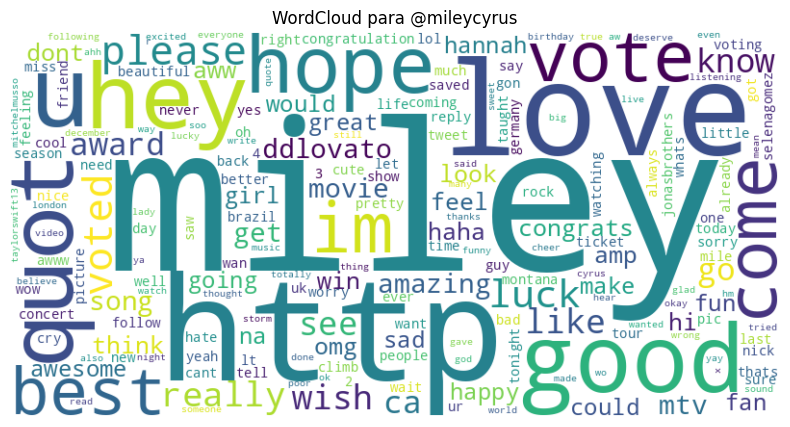

WordCloud para @tommcfly


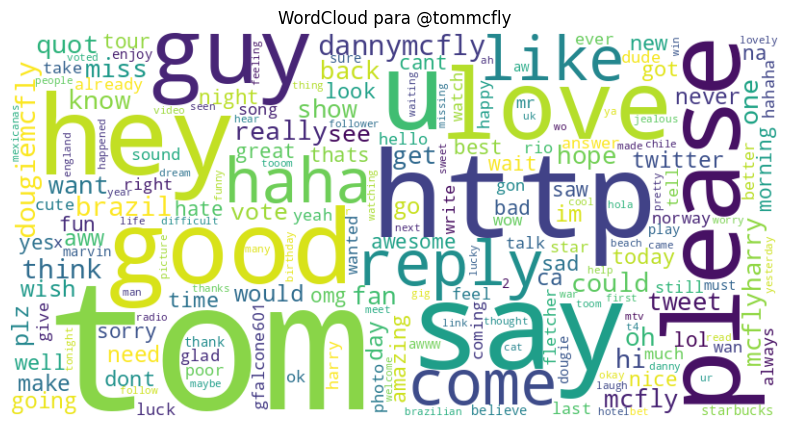

WordCloud para @ddlovato


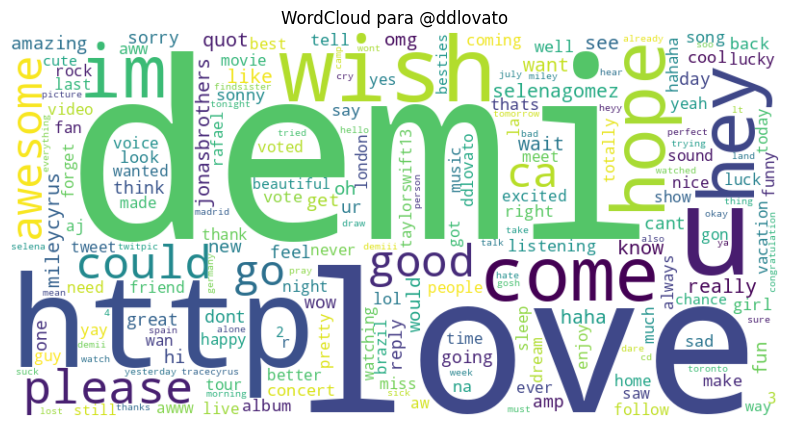

In [32]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generar y mostrar un WordCloud
def generate_wordcloud(context_counter, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(context_counter)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# WordClouds de los tres usuarios más populares
for user in top_users_list:
    print(f"WordCloud para {user}")
    generate_wordcloud(user_context[user], f"WordCloud para {user}")